In [36]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import warnings

In [37]:
from featureExtraction import *
from dataAnalyzer import *
from private_tool import *
from dataHandler import *

In [38]:
warnings.filterwarnings('ignore')

In [39]:
experimentNum = 9
Experiments = [MotorImageryDataset(parentDirectory(dir=currDir, separator="\\", n=1)+'/bcicompetitionIV2a/A0'+str(i+1)+'T.npz') for i in range(experimentNum)]

In [292]:
experimentIdx = 3

In [293]:
channels = list(range(25))
samplingRate = 250 #Hz
trialsByClasses = np.array([i.get_trials_by_classes(channels=channels) for i in Experiments])

In [294]:
channelNum = len(channels)
m = len(trialsByClasses[0]["left"])
channelNum, m

(25, 25)

In [295]:
bandpassedTrialsByClasses = [{i:[[] for _ in range(channelNum)] for i in j.mi_types.values()} for j in Experiments]
for k in range(experimentNum):
    for key in trialsByClasses[k].keys():
        for i in range(channelNum):
            bandpassedTrialsByClasses[k][key][i] = np.array([bandpass_filter(data=trialsByClasses[k][key][i][j], 
                                                                sample_rate=samplingRate, 
                                                                cutoff_low=7, 
                                                                cutoff_high=30)\
                                                for j in range(len(trialsByClasses[k][key][i]))])

In [296]:
# 현재 상태는 experiment - class - channel - trial - signal
# class - experiment - trial - channel - signal로 수정하자
bandpassedTrialsByClasses = {key: np.array([[bandpassedTrialsByClasses[i][key][j] for j in range(channelNum)] for i in range(experimentNum)]) for key in Experiments[0].mi_types.values()}
# i: experiment
# j: trial

In [297]:
minTrialsNum = sorted([sorted([len(bandpassedTrialsByClasses["left"][i][0]) for i in range(experimentNum)])[0], sorted([len(bandpassedTrialsByClasses["right"][i][0]) for i in range(experimentNum)])[0], sorted([len(bandpassedTrialsByClasses["tongue"][i][0]) for i in range(experimentNum)])[0], sorted([len(bandpassedTrialsByClasses["foot"][i][0]) for i in range(experimentNum)])[0]])[0]
bandpassedTrialsByClasses = {i:[bandpassedTrialsByClasses[i][j] for j in range(experimentNum)] for i in Experiments[0].mi_types.values()}
minTrialsNum

49

In [298]:
left_csp_filter = CSP_filter(np.array([i[:minTrialsNum] for i in bandpassedTrialsByClasses["left"][experimentIdx]]), np.array([j[:minTrialsNum] for i in ["right", "tongue", "foot"] for j in bandpassedTrialsByClasses[i][experimentIdx]]))
right_csp_filter = CSP_filter(np.array([i[:minTrialsNum] for i in bandpassedTrialsByClasses["right"][experimentIdx]]), np.array([j[:minTrialsNum] for i in ["left", "right", "tongue", "foot"] for j in bandpassedTrialsByClasses[i][experimentIdx]]))
tongue_csp_filter = CSP_filter(np.array([i[:minTrialsNum] for i in bandpassedTrialsByClasses["tongue"][experimentIdx]]), np.array([j[:minTrialsNum] for i in ["left", "tongue", "foot"] for j in bandpassedTrialsByClasses[i][experimentIdx]]))
foot_csp_filter = CSP_filter(np.array([i[:minTrialsNum] for i in bandpassedTrialsByClasses["foot"][experimentIdx]]), np.array([j[:minTrialsNum] for i in ["left", "right", "tongue"] for j in bandpassedTrialsByClasses[i][experimentIdx]]))

In [299]:
bandpassedTrials = {i:[] for i in Experiments[0].mi_types.values()}
for i in Experiments[0].mi_types.values():
    for j in range(len(bandpassedTrialsByClasses)):
        bandpassedTrials[i]

In [300]:
# CSP_passed_left_data = np.array([[bandpassedTrialsByClasses[i][j].T@left_csp_filter for j in range(minTrialsNum)] for i in range(experimentNum)])
CSP_passed_left_data = [j[:minTrialsNum].T@left_csp_filter for j in bandpassedTrialsByClasses["left"][experimentIdx]]
CSP_passed_right_data = [j[:minTrialsNum].T@right_csp_filter for j in bandpassedTrialsByClasses["right"][experimentIdx]]
CSP_passed_tongue_data = [j[:minTrialsNum].T@tongue_csp_filter for j in bandpassedTrialsByClasses["tongue"][experimentIdx]]
CSP_passed_foot_data = [j[:minTrialsNum].T@foot_csp_filter for j in bandpassedTrialsByClasses["foot"][experimentIdx]]

In [301]:
len(CSP_passed_left_data)

25

In [302]:
# bandpassedTrialsByClasses["right"][0]["right"][0]

In [303]:
CSP_passed_left_data = [np.array([j.T for j in i]).T for i in CSP_passed_left_data]
CSP_passed_right_data = [np.array([j.T for j in i]).T for i in CSP_passed_right_data]
CSP_passed_tongue_data = [np.array([j.T for j in i]).T for i in CSP_passed_tongue_data]
CSP_passed_foot_data = [np.array([j.T for j in i]).T for i in CSP_passed_foot_data]
np.array(CSP_passed_left_data).shape

(25, 49, 1875)

In [304]:
CSP_passed_left_data = np.array([i.T for i in np.array(CSP_passed_left_data).T]).T
CSP_passed_right_data = np.array([i.T for i in np.array(CSP_passed_right_data).T]).T
CSP_passed_tongue_data = np.array([i.T for i in np.array(CSP_passed_tongue_data).T]).T
CSP_passed_foot_data = np.array([i.T for i in np.array(CSP_passed_foot_data).T]).T
CSP_passed_left_data.shape

(49, 25, 1875)

In [305]:
m = 2

leftVarRatioDF = twoMDimensionalFeature(CSP_passed_left_data, channelNum, minTrialsNum, m)
rightVarRatioDF = twoMDimensionalFeature(CSP_passed_right_data, channelNum, minTrialsNum, m)
tongueVarRatioDF = twoMDimensionalFeature(CSP_passed_tongue_data, channelNum, minTrialsNum, m)
footVarRatioDF = twoMDimensionalFeature(CSP_passed_foot_data, channelNum, minTrialsNum, m)

VarRatioDF = pd.concat([leftVarRatioDF, rightVarRatioDF, tongueVarRatioDF, footVarRatioDF], axis=0)
labelDF = pd.DataFrame([i for i in range(4) for j in range(minTrialsNum)])

VarRatioDF = VarRatioDF.reset_index()
VarRatioDF = pd.concat([VarRatioDF, labelDF], axis=1).iloc[:, 1:]
VarRatioDF.columns = [f"{n}" for n in range(m*2)] + ["target"]
VarRatioDF

,0,1,2,3,target
0,-3.277757,-3.376506,-3.246476,-3.161786,0
1,-3.230231,-3.332961,-3.235855,-3.067370,0
2,-3.362791,-3.431655,-3.285243,-3.185976,0
3,-3.332747,-3.461460,-3.327108,-3.179161,0
4,-3.317241,-3.361961,-3.248947,-3.154070,0
...,...,...,...,...,...
191,-3.136947,-3.398981,-3.218442,-3.075748,3
192,-3.270862,-3.434735,-3.265425,-3.136778,3
193,-3.394505,-3.485908,-3.374737,-3.246010,3
194,-3.308178,-3.492196,-3.381847,-3.253145,3


In [306]:
x = VarRatioDF.drop(['target'], axis=1).values 
y = VarRatioDF['target'].values # 종속변인 추출
x = StandardScaler().fit_transform(x)
pd.DataFrame(x)

,0,1,2,3
0,0.100646,0.496535,0.437679,0.171007
1,0.669439,1.117037,0.591593,1.498806
2,-0.917036,-0.289348,-0.124131,-0.169188
3,-0.557465,-0.714058,-0.730825,-0.073351
4,-0.371892,0.703801,0.401868,0.279518
...,...,...,...,...
191,1.785860,0.176256,0.843937,1.380996
192,0.183171,-0.333234,0.163070,0.522700
193,-1.296585,-1.062447,-1.421066,-1.013472
194,-0.263424,-1.152044,-1.524103,-1.113803


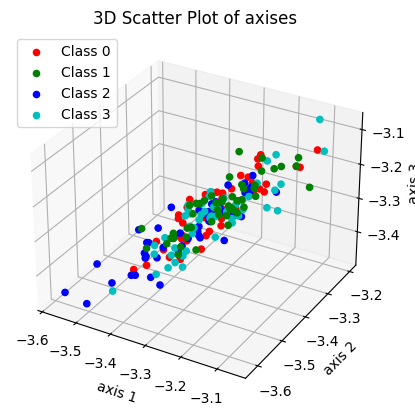

In [307]:
plotDF3D(data=VarRatioDF, num_of_classes=4)

In [308]:
cross_validation("linear", VarRatioDF.drop(['label'], axis=1).values , labelDF)
cross_validation("rbf", VarRatioDF.drop(['label'], axis=1).values , labelDF)

교차검증 평균:  0.29089743589743594
교차검증 평균:  0.2602564102564103


In [309]:
n_componunts = 4
PCA = PrincipalComponuntAnalysis(n_componunts=n_componunts, data=x)
principalDF = PCA.principalDf

In [310]:
sum(PCA.explained_variance_ratio_())

0.9999999999999999

In [311]:
cross_validation("linear", principalDF, labelDF)
cross_validation("rbf", principalDF, labelDF)

교차검증 평균:  0.2708974358974359
교차검증 평균:  0.2653846153846154


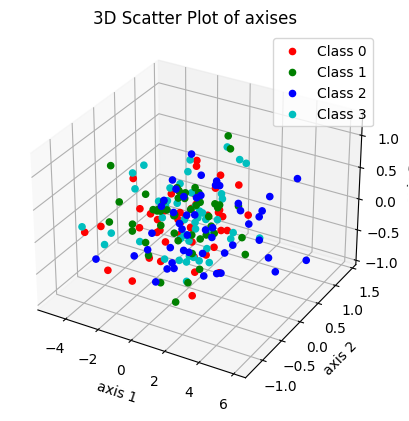

In [312]:
df = pd.concat([principalDF, labelDF], axis=1)
plotDF3D(data=df, num_of_classes=4)

In [313]:
np.save(currDir+"/test.npy", VarRatioDF)

In [314]:
LDA_DF = pd.concat([pd.DataFrame(LDATransform(principalDF, labelDF, 3, "eigen")), labelDF], axis=1)
LDA_DF.columns = [f"axis{i+1}" for i in range(3)] + ["label"]

In [315]:
cross_validation("linear", LDA_DF.loc[:,:"axis3"], labelDF)
cross_validation("rbf", LDA_DF.loc[:,:"axis3"], labelDF)

교차검증 평균:  0.2862820512820513
교차검증 평균:  0.2553846153846154


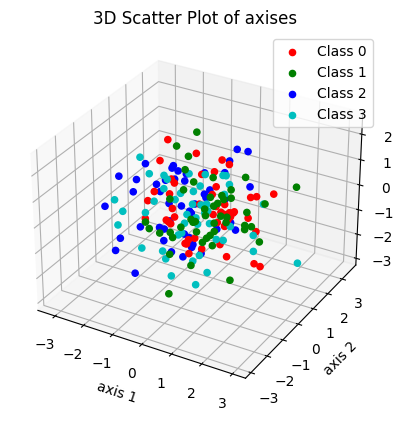

In [316]:
plotDF3D(data=LDA_DF, num_of_classes=4)

In [317]:
scaler = StandardScaler()
scaler.fit(LDA_DF.loc[:, :"axis3"])
LDA_DF_Scaled = pd.concat([pd.DataFrame(scaler.transform(LDA_DF.loc[:, :"axis3"])), labelDF], axis=1)
LDA_DF_Scaled.columns = [f"axis{i+1}" for i in range(3)] + ["label"]

In [318]:
cross_validation("linear", LDA_DF_Scaled.loc[:,:"axis3"], labelDF)
cross_validation("rbf", LDA_DF_Scaled.loc[:,:"axis3"], labelDF)

교차검증 평균:  0.2862820512820513
교차검증 평균:  0.26564102564102565


In [319]:
np.save(currDir+"/test.npy", LDA_DF_Scaled)

In [320]:
from sklearn.model_selection import GridSearchCV

# 테스트하고자 하는 파라미터 값들을 사전타입으로 정의

svm_clf = svm.SVC(kernel = 'rbf',random_state=100)
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 25, 50, 100],
             'gamma':[0.001, 0.01, 0.1, 1, 10, 25, 50, 100]}

grid_svm = GridSearchCV(svm_clf,
                      param_grid = parameters, cv = 5)

grid_svm.fit(LDA_DF.loc[:,:"axis3"], labelDF)

result = pd.DataFrame(grid_svm.cv_results_['params'])
result['mean_test_score'] = grid_svm.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)

,C,gamma,mean_test_score
43,25.000,1.000,0.336923
51,50.000,1.000,0.321667
35,10.000,1.000,0.311154
59,100.000,1.000,0.306282
48,50.000,0.001,0.301538
...,...,...,...
17,0.100,0.010,0.219615
16,0.100,0.001,0.214615
8,0.010,0.001,0.214615
24,1.000,0.001,0.214615
